In [43]:
import random
import numpy as np
from ParticleClass import hello as hell
from FuncionesGeneradorasListas import FuncionesListas as fl
import matplotlib.pyplot as plt
from FGeneradora import FuncionGeneradora as fg
import scipy

In [3]:
%load_ext Cython

In [6]:
help(hell.Particula)

Help on class Particula in module ParticleClass.hello:

class Particula(builtins.object)
 |  Particula(posicion, velocidad, masa, radio)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, posicion, velocidad, masa, radio)
 |      comenzamos definiendo el método que debe 
 |      inicializar la clase, en este definimos los atributos básicos de la clase partícula
 |      las entradas masa y radio son de tipo float y las entradas de posición son tuplas conformadas por floats
 |  
 |  paso_dt(self, dt)
 |      Este método lo que hace es avanzar en el tiempo, cambia la posición de la partícula
 |  
 |  resolver_colision_esquina(self)
 |      Método que actualiza la velocidad después de que una partícula choca con una esquina
 |  
 |  resolver_colision_muro(self, Lx, Ly)
 |      #Método que actualiza la velocidad después de que una partícula choca con un muro. Recibe la
 |      partícula y las dimensiones de la caja
 |  
 |  resolver_colision_particula(self, otra_p)
 |      Método que ac

In [4]:
%%cython 
#Se importan las cosas necesarias 
from ParticleClass import hello as hell
import timeit
from FuncionesGeneradorasListas import FuncionesListas as fl
import matplotlib.pyplot as plt
from FGeneradora import FuncionGeneradora as fg
import multiprocessing as mp 

#########################FUNCIÓN QUE REALIZA LA SIMULACIÓN##############################################
def simulate(float v1, float v2, float dt, float Lx, float Ly, int n, float m, float r, int nt):
    cdef int j,k,i   #Fijamos j,k,i como enteros. Estos van a ser las variables con que se itera.
    par = fg.funcion_generadora(Lx,Ly,v1,v2,m,r,n) #se crea la configuración inicial de las partículas
    lista_posiciones = fl.listas_para_llenar_posiciones(n) ## lista que contiene las posiciones de cada partícula 
                                                           ## en cada paso
    lista_velocidades = fl.listas_para_llenar_componentes_velocidad(n) #Lista con las velocidades

    for j in range(nt):

        for k in range(n):
            lista_posiciones[k][0].append(par[k].posicion[0])  #Se añade la posición en x de cada partícula
            lista_posiciones[k][1].append(par[k].posicion[1])  #Se añade la posicion en y de cada partícula
            lista_velocidades[k][0].append(par[k].velocidad[0]) #Se añade la velocidad en x de cada partícula
            lista_velocidades[k][1].append(par[k].velocidad[1]) #Se añade la velocidad en y de cada partícula
        for p in par:     
            for i in range(par.index(p)+1,n): #Revisamos las colisiones entre partículas
                if  p.posicion[0] == par[i].posicion[0] and p.posicion[1] == par[i].posicion[1]:
                    continue 

                elif p.ver_colision_pp(par[i])  :
                    #print("CHOQUE")
                    p.resolver_colision_particula(par[i])
        for p in par: 
            if p.ver_colision_muro(Lx,Ly): #Revisamos las condiciones de choque con la caja
                p.resolver_colision_muro(Lx,Ly)
            elif p.ver_colision_esquina(Lx,Ly): #Revisamos las condiciones de choque con las esquinas
                p.resolver_colision_esquina()
            p.paso_dt(dt)
    return lista_posiciones, lista_velocidades, par   #Retorna la lista con las posiciones y la lista con las velocidades
#####################################################################################################



CPU times: user 85.7 ms, sys: 12.8 ms, total: 98.5 ms
Wall time: 5.38 s


In [54]:
%time
#Parametros simulación
v1 = 0  #Velocidad mínima
v2 = 250  #Velocidad máxima
dt = 0.01 #tamaño del paso
Lx = 200 #Tamñaño de la caja 
Ly = 200 
n = 100 #número de partículas
m = 1 #masa 
r = 2 #radio
nt  = 1000 #número de pasos


c = simulate(v1,v2,dt,Lx,Ly,n,m,r,nt)
lista_posiciones = c[0]
lista_velocidades = c[1]
par = c[2]

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.3 µs


In [55]:
nt = 1000
n = 100
lista_cuadrados_velocidades = [] #Aquí vamos a guardar los cuadrados de las velocidades 
lista_magnitudes_velocidades = [] #Aquí vamos a guardar todas las magnitudes en cada paso
for _ in range(nt):
    lista_magnitudes_velocidades.append([])   #Para cada paso creamos una lista
    lista_cuadrados_velocidades.append([])

In [56]:
for z in range(nt):
      for  velocidad_particula in lista_velocidades: ##Barrimos la lista de velocidades
            lista_magnitudes_velocidades[z].append(np.sqrt(velocidad_particula[0][z]**2 + velocidad_particula[1][z]**2))
             #Se añade la magnitud de la partícula velocidad_particula en el paso z

AQUÍ VIENE LA PRUEBA CON LO QUE HA HECHO MATEO 

In [8]:
#######################FUNCIÓN DE TEMPERATURA#########################
def temperatura(n,lista_v,m):#La función recibe el número de partículas, la lista de velcidades que va a provenir de la simulación
    l=[]                     #y la masa de las partículas(esta será igual siempre y la podremos sacar de los parámetros)
    for i in range(n):      
    
      v_x=lista_v[i][0][-1]
      v_y=lista_v[i][1][-1]
      v_cuadrado=(v_x)**2+(v_y)**2  
      l.append(v_cuadrado)
     
    Temperatura=0.5*m*(sum(l)/(len(l)))#Se calcula el promedio de la energía cinética en todo el gas para el último paso
    return Temperatura


In [36]:
def Temperatura1(par): #Recibe la lista de partículas y la masa
    E = []
    for p in par:
        E.append(p.velocidad_mag**2 * p.masa * 0.5)
    return sum(E)/len(E)
    
Temperatura1(par)
        
    

22206.881092578686

In [57]:
from scipy import stats
from scipy import constants as con
res = scipy.stats.relfreq(lista_magnitudes_velocidades[1], numbins=14)
x = res.lowerlimit + np.linspace(0, res.binsize*res.frequency.size,res.frequency.size)

In [52]:
res.binsize

24.375366065781414

In [10]:
#################PREPARAMOS LA DISTRIBUCIÓN DE MAXWELL-BOLTZMANN##############
u = np.linspace(0,2.5*v2,10000)  #Se multiplica por 2.5 porque hay partículas que obtienen velocidades mayores a v2
kT = temperatura(par)  #función que calcula la temperatura 
MBdistribution = (m*u)/(kT) * np.exp(-(m*u**2)/(2*kT))



TypeError: temperatura() missing 1 required positional argument: 'm'

In [63]:
print(u[10000-1])

625.0


In [79]:
max(MBdistribution)

0.004160299138704132

<IPython.core.display.Javascript object>


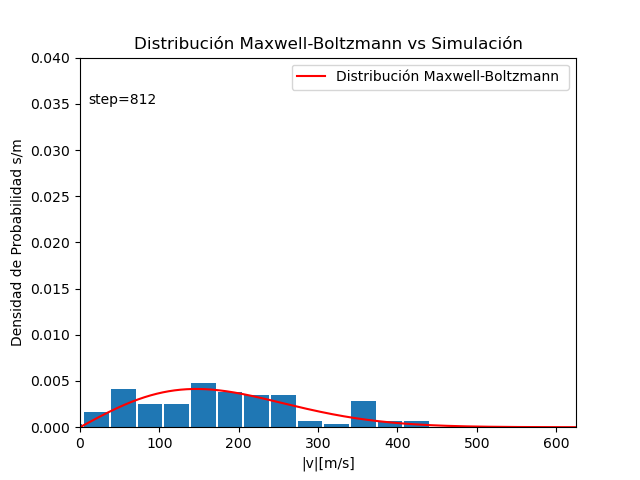

In [88]:
#Esto deja la animación en el notebook
%matplotlib notebook  
import matplotlib.animation as animation
fig = plt.figure()
def update_hist(i):        ##Para usar FuncAnimation hay que tener una función que diga en cada frame cuales son los parametros
                           ##de lo que se va a poner en el frame. Lo único que hice fue 
    plt.cla() #Esto limpia el canvas antes de poner el frame, de lo contrario se amontonan
    
    ###################PREPARAMOS LA DISTRIBUCIÓN#############################
    u = np.linspace(0,2.5*v2,10000)  #Se multiplica por 2.5 porque hay partículas que obtienen velocidades mayores a v2
    kT = Temperatura1(par)  #función que calcula la temperatura 
    MBdistribution = (m*u)/(kT) * np.exp(-(m*(u**2))/(2*kT))
    plt.plot(u,MBdistribution, color = 'red',label = 'Distribución Maxwell-Boltzmann ') #Se pone la distribución
    plt.xlim(0,2.5*v2) #Se multiplica por 2.5 porque hay partículas que obtienen velocidades mayores a v2
    plt.ylim(0,1/25)
    plt.legend()
    plt.ylabel('Densidad de Probabilidad s/m')                
    plt.xlabel('|v|[m/s]')
    ############################
    #########################################
    res = scipy.stats.relfreq(lista_magnitudes_velocidades[i], numbins=14)
    x = res.lowerlimit + np.linspace(0, res.binsize*res.frequency.size,res.frequency.size)
    ax = fig.add_subplot(1, 1, 1)         #############Todo este código lo saqué de la documentación
    ax.bar(x, res.frequency/res.binsize, width=res.binsize, label = 'Simulación')
    ax.set_title('Distribución Maxwell-Boltzmann vs Simulación')
    ##################################
    plt.text(10.040,0.035,'step={}'.format(i))
                                        #Llama la función   #hace 10000 porque hay 10000 pasos, este es el número de frames
animation = animation.FuncAnimation(fig, update_hist,1000)
plt.show()

